# Import Modules

In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin

# miscellaneous
from IPython.display import clear_output

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


# Load & Manipulate Data

In [ ]:
# NOT RUN: data manipulation -- concatenate data across datasets, store into a new file

# need to make sure the directory containing data is downloaded to local
# otherwise will encounter the error "resource deadlock avoided"

# data_UIC_CAR = hddm.load_csv("all_cleaned/CAR_UIC_flanker_cleaned.csv")
# data_USC_CAR = hddm.load_csv("all_cleaned/CAR_USC_flanker_cleaned.csv")
# data_UIC_PARC = hddm.load_csv("all_cleaned/PARC_UIC_flanker_cleaned.csv")
# data_USC_PARC = hddm.load_csv("all_cleaned/PARC_USC_flanker_cleaned.csv")

# data_UIC_CAR["school"] = "UIC"
# data_USC_CAR["school"] = "USC"
# data_UIC_PARC["school"] = "UIC"
# data_USC_PARC["school"] = "USC"

# data_CAR = pd.concat((data_UIC_CAR, data_USC_CAR), axis=0)
# MDD = pd.read_csv("MDD_all.csv")
# MDD = MDD.rename(columns={"ID": "subject_id", "MDDnew": "group"})
# MDD.loc[MDD.group == 0, 'group'] = "HC"
# MDD.loc[MDD.group == 1, 'group'] = "rMDD"
# data_CAR = pd.merge(data_CAR, MDD, on = "subject_id")

# data_PARC = pd.concat((data_UIC_PARC, data_USC_PARC), axis=0)
# data_PARC["group"] = "SI"
# data = pd.concat((data_CAR, data_PARC), axis=0)

# data.to_csv("all_cleaned/flanker_all.csv", index=False)

In [2]:
# load data
data = hddm.load_csv("all_cleaned/flanker_all.csv")

In [3]:
# exclude rows according to the exclusion flags
data_clean = data.loc[(data.exclude_trial == 0) & (data.exclude_part == 0), :]

In [4]:
print("Number of trials, before exclusion: ", data.shape[0])
print("Number of trials, after exclusion: ", data_clean.shape[0])
print("Number of trials per person: ", data_clean.loc[data_clean.subject_id==data_clean.subject_id[0]].shape[0])
print("Number of variables: ", data_clean.shape[1])
print("Number of participants, before exclusion: ", data.subject_id.unique().shape[0])
print("Number of participants, after exclusion: ", data_clean.subject_id.unique().shape[0])

Number of trials, before exclusion:  6288
Number of trials, after exclusion:  6231
Number of trials per person:  48
Number of variables:  12
Number of participants, before exclusion:  131
Number of participants, after exclusion:  131


In [4]:
# rename columns according to the HDDM model convention
data_clean = data_clean.rename(columns={"resp_rt": "rt", "resp_value": "response",
                                        "trial_congruent_fac": "trial_type",
                                        "subject_id": "subj_idx"})

In [13]:
data_clean.head()

,subj_idx,trial_type,resp_corr,rt,response,mean_rt,sd_rt,exclude_thresh,exclude_trial,exclude_part,school,group
0,1903,congruent,1,0.841311,left,0.945541,0.158969,2.4,0,0,UIC,rMDD
1,1903,incongruent,1,1.105856,right,1.020937,0.151395,2.4,0,0,UIC,rMDD
2,1903,incongruent,1,1.151826,left,1.020937,0.151395,2.4,0,0,UIC,rMDD
3,1903,congruent,1,0.710728,right,0.945541,0.158969,2.4,0,0,UIC,rMDD
4,1903,incongruent,1,0.956795,left,1.020937,0.151395,2.4,0,0,UIC,rMDD


# Variable Coding

In [5]:
# flip RTs of incorrect trials in the negative direction
data_clean.loc[data_clean.resp_corr == 0, 'rt'] = data_clean.loc[data_clean.resp_corr == 0, 'rt']*(-1)

# Model Specification

| Models | Model Parameters | # Params |
|-|-|-|  
| m0 | 'a', 'v', 't', 'z'| 4 |
| m1 | 'a', 'v_con', 'v_incon', 't','z' | 5 |
| m1_sv | 'a', 'v_con', 'v_incon', 't','z', 'sv' | 6 |
| m1_svsz | 'a', 'v_con', 'v_incon', 't', 'z', 'sv', 'sz' | 7 |
| m2 | 'a_con', 'a_incon', 'v_con', 'v_incon', 't', 'z' | 6 |
| m2_sv | 'a_con', 'a_incon', 'v_con', 'v_incon', 't', 'z', 'sv' | 7 |
| m2_svsz | 'a_con', 'a_incon', 'v_con', 'v_incon', 't', 'z', 'sv', 'sz' | 8 |
| m3 | 'a', 'v_con', 'v_incon', 't_con', 't_incon', 'z' | 6 |
| m3_sv | 'a', 'v_con', 'v_incon', 't_con', 't_incon', 'z', 'sv' | 7 |
| m3_svsz | 'a', 'v_con', 'v_incon', 't_con', 't_incon', 'z', 'sv', 'sz' | 8 |
| m4 | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z' | 7 |
| m4_sv | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z', 'sv' | 8 |
| m4_svsz | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z', 'sv', 'sz' | 9 |
| m5 | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z_con', 'z_incon' | 8 |
| m5_sv | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z_con', 'z_incon', 'sv' | 9 |
| m5_svsz | 'a_con', 'a_incon', 'v_con', 'v_incon', 't_con', 't_incon', 'z_con', 'z_incon', 'sv', 'sz' | 10 |


## Parameters
- v: drift rate
- a: threshold/boundary separation
- t: non-decision time
- z: bias
- sX: inter-trial variability in X (e.g., sv: inter-trial variability in drift rate)


In [8]:
df = data_clean.copy()
# data_cavanagh = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')

# Model 0: base model with no inter-trial variability in parameters
# m0 = hddm.HDDM(df, include=['a', 'v', 't', 'z'])

# Model 1: a, v_con, v_incon, t, z
# m1 = hddm.HDDM(df, include=['a', 'v', 't', 'z'], 
#                depends_on={'v': 'trial_type'})

# Model 1_sv
# m1_sv = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv'], 
#                   depends_on={'v': 'trial_type'})

# Model 1_svsz
# m1_svsz = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz'], 
#                     depends_on={'v': 'trial_type'})

# Model 2: a_con, a_incon, v_con, v_incon, t, z
# m2 = hddm.HDDM(df, include=['a', 'v', 't', 'z'], 
#                depends_on={'v': 'trial_type', 'a': 'trial_type'})

# Model 2_sv
# m2_sv = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv'], 
#                   depends_on={'v': 'trial_type', 'a': 'trial_type'})

# Model 2_svsz
# m2_svsz = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz'], 
#                     depends_on={'v': 'trial_type', 'a': 'trial_type'})

# Model 3: a, v_con, v_incon, t_con, t_incon, z
# m3 = hddm.HDDM(df, include=['a', 'v', 't', 'z'], 
#                depends_on={'v': 'trial_type', 't': 'trial_type'})

# Model 3_sv
# m3_sv = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv'], 
#                   depends_on={'v': 'trial_type', 't': 'trial_type'})

# Model 3_svsz
# m3_svsz = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz'], 
#                     depends_on={'v': 'trial_type', 't': 'trial_type'})

# Model 4: a_con, a_incon, v_con, v_incon, t_con, t_incon, z
# m4 = hddm.HDDM(df, include=['a', 'v', 't', 'z'], 
#                depends_on={'v': 'trial_type', 't': 'trial_type',
#                            'a': 'trial_type'})

# Model 4_sv
# m4_sv = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv'], 
#                   depends_on={'v': 'trial_type', 't': 'trial_type',
#                               'a': 'trial_type'})

# Model 4_svsz (BEST FITTING MODEL IN RAPPAPORT ET AL 2024)
# m4_svsz = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz'], 
#                     depends_on={'v': 'trial_type', 't': 'trial_type', 
#                                 'a': 'trial_type'})

# Model 5: a_con, a_incon, v_con, v_incon, t_con, t_incon, z_con, z_incon
# m5 = hddm.HDDM(df, include=['a', 'v', 't', 'z'], 
#                depends_on={'v': 'trial_type', 't': 'trial_type',
#                            'a': 'trial_type', 'z': 'trial_type'})

# Model 5_sv
# m5_sv = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv'], 
#                   depends_on={'v': 'trial_type', 't': 'trial_type',
#                               'a': 'trial_type', 'z': 'trial_type'})

# Model 5_svsz
m5_svsz = hddm.HDDM(df, include=['a', 'v', 't', 'z', 'sv', 'sz'], 
                  depends_on={'v': 'trial_type', 't': 'trial_type',
                              'a': 'trial_type', 'z': 'trial_type'})


# Model 2: regression model (varying intercept and slope)
# m2 = hddm.HDDMRegressor(
#   df, "v ~ 1 + C(trial_type, Treatment('incongruent'))", 
#   include=['a', 'v', 't', 'z'], 
#   group_only_regressors=False, 
#   keep_regressor_trace=True)

# Model 3: regression model (varying intercept and slope)
# m3 = hddm.HDDMRegressor(
#   df, "v ~ 1 + C(trial_type, Treatment('incongruent'))", 
#   include=['a', 'v', 't', 'z'], 
#   group_only_regressors=False, 
#   keep_regressor_trace=True)

No model attribute --> setting up standard HDDM
Set model to full_ddm


# Model Fitting

In [9]:
def run_sampling(
    m,
    n_samples=10000,
    n_burn=5000,
    n_chains=4,
    model_name="m",
    progress_bar=True,
):
    """
    Run Markov Chain Monte Carlo (MCMC) sampling for a given model and parameters.
    This function takes a model parameter `m` and runs MCMC sampling using PyMC2.3.8.
    It returns a arviz InferenceData object containing the posterior samples and post-fit model.
    Parameters
    ----------
    m : object
        The model parameter to be sampled.
    n_samples : int, optional
        The number of posterior samples to generate. Default is 10000.
    n_burn : int, optional
        The number of initial samples to discard. Default is 5000.
    n_chains : int, optional
        The number of MCMC chains to run in parallel. Default is 4.
    model_name : str, optional
        The name of the model to be used in the sampling process. Default is "m".
    progress_bar : boolean, optional
        Default=True. Set False hide sampling progress bar. 
    Returns
    -------
    InferenceData : arviz.InferenceData
        A trace object containing the posterior samples.
    Model: HDDM
        A post-fit HDDM model. 
    """
    print("Finding starting values.")
    m.find_starting_values()
    print("Fitting model.")
    m_infdata = m.sample(n_samples,
                         burn=n_burn,
                         chains=n_chains,
                         return_infdata=True,
                         save_name="../models/" + model_name,
                         progress_bar=progress_bar)

    return m, m_infdata

In [10]:
models = {"m5_svsz": m5_svsz}
for model_name in models.keys():
    clear_output()
    print("Fitting "+model_name)
    model = models[model_name]
    %time
    m, m_infdata = run_sampling(model, n_samples=2000, n_burn=200, model_name=model_name)

Fitting m5_svsz
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Finding starting values.


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Fitting model.


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[                  0%                  ] 2 of 2000 complete in 1.8 sec
[                  0%                  ] 3 of 2000 complete in 3.2 sec
[                  0%                  ] 4 of 2000 complete in 4.9 sec
[                  0%                  ] 5 of 2000 complete in 6.2 sec
[                  0%                  ] 6 of 2000 complete in 7.4 sec
[                  0%                  ] 7 of 2000 complete in 8.7 sec
[                  0%                  ] 8 of 2000 complete in 10.0 sec
[                  0%                  ] 9 of 2000 complete in 11.4 sec
[                  0%                  ] 10 of 2000 complete in 12.9 sec
[                  0%                  ] 11 of 2000 complete in 14.4 sec
[                  0%                  ] 12 of 2000 complete in 15.5 sec
[                  0%                  ] 13 of 2000 complete in 16.6 sec
[                  0%                  ] 14 of 2000 complete in 17.9 sec
[                  0%                  ] 15 of 2000 complete in 1

[--                5%                  ] 113 of 2000 complete in 151.2 sec
[--                5%                  ] 114 of 2000 complete in 152.6 sec
[--                5%                  ] 115 of 2000 complete in 154.4 sec
[--                5%                  ] 116 of 2000 complete in 155.9 sec
[--                5%                  ] 117 of 2000 complete in 157.3 sec
[--                5%                  ] 118 of 2000 complete in 158.7 sec
[--                5%                  ] 119 of 2000 complete in 160.4 sec
[--                6%                  ] 120 of 2000 complete in 161.7 sec
[--                6%                  ] 121 of 2000 complete in 163.3 sec
[--                6%                  ] 122 of 2000 complete in 165.0 sec
[--                6%                  ] 123 of 2000 complete in 166.3 sec
[--                6%                  ] 124 of 2000 complete in 167.8 sec
[--                6%                  ] 125 of 2000 complete in 169.4 sec
[--                6%    

[--                5%                  ] 113 of 2000 complete in 150.8 sec
[--                5%                  ] 114 of 2000 complete in 152.4 sec
[--                5%                  ] 115 of 2000 complete in 154.5 sec
[--                5%                  ] 116 of 2000 complete in 155.9 sec
[--                5%                  ] 117 of 2000 complete in 157.3 sec
[--                5%                  ] 118 of 2000 complete in 158.9 sec
[--                5%                  ] 119 of 2000 complete in 160.4 sec
[--                6%                  ] 120 of 2000 complete in 161.7 sec
[--                6%                  ] 121 of 2000 complete in 163.5 sec
[--                6%                  ] 122 of 2000 complete in 165.1 sec
[--                6%                  ] 123 of 2000 complete in 166.3 sec
[--                6%                  ] 124 of 2000 complete in 167.6 sec
[--                6%                  ] 125 of 2000 complete in 169.2 sec
[--                6%    

[----             11%                  ] 222 of 2000 complete in 307.7 sec
[----             11%                  ] 223 of 2000 complete in 308.9 sec
[----             11%                  ] 224 of 2000 complete in 310.0 sec
[----             11%                  ] 225 of 2000 complete in 311.5 sec
[----             11%                  ] 226 of 2000 complete in 312.9 sec
[----             11%                  ] 227 of 2000 complete in 314.2 sec
[----             11%                  ] 228 of 2000 complete in 315.4 sec
[----             11%                  ] 229 of 2000 complete in 317.0 sec
[----             11%                  ] 230 of 2000 complete in 318.7 sec
[----             11%                  ] 231 of 2000 complete in 320.0 sec
[----             11%                  ] 232 of 2000 complete in 321.2 sec
[----             11%                  ] 233 of 2000 complete in 322.4 sec
[----             11%                  ] 234 of 2000 complete in 323.7 sec
[----             11%    

[----             11%                  ] 222 of 2000 complete in 302.3 sec
[----             11%                  ] 223 of 2000 complete in 303.6 sec
[----             11%                  ] 224 of 2000 complete in 304.9 sec
[----             11%                  ] 225 of 2000 complete in 306.0 sec
[----             11%                  ] 226 of 2000 complete in 307.1 sec
[----             11%                  ] 227 of 2000 complete in 308.3 sec
[----             11%                  ] 228 of 2000 complete in 309.6 sec
[----             11%                  ] 229 of 2000 complete in 310.7 sec
[----             11%                  ] 230 of 2000 complete in 312.2 sec
[----             11%                  ] 231 of 2000 complete in 313.5 sec
[----             11%                  ] 232 of 2000 complete in 314.7 sec
[----             11%                  ] 233 of 2000 complete in 316.0 sec
[----             11%                  ] 234 of 2000 complete in 317.5 sec
[----             11%    

[------           16%                  ] 331 of 2000 complete in 457.3 sec
[------           16%                  ] 332 of 2000 complete in 458.6 sec
[------           16%                  ] 333 of 2000 complete in 460.0 sec
[------           16%                  ] 334 of 2000 complete in 461.5 sec
[------           16%                  ] 335 of 2000 complete in 462.8 sec
[------           16%                  ] 336 of 2000 complete in 464.1 sec
[------           16%                  ] 337 of 2000 complete in 465.2 sec
[------           16%                  ] 338 of 2000 complete in 466.4 sec
[------           16%                  ] 339 of 2000 complete in 467.6 sec
[------           17%                  ] 340 of 2000 complete in 468.9 sec
[------           17%                  ] 341 of 2000 complete in 470.1 sec
[------           17%                  ] 342 of 2000 complete in 471.3 sec
[------           17%                  ] 343 of 2000 complete in 472.5 sec
[------           17%    

[------           16%                  ] 331 of 2000 complete in 467.9 sec
[------           16%                  ] 332 of 2000 complete in 469.6 sec
[------           16%                  ] 333 of 2000 complete in 470.9 sec
[------           16%                  ] 334 of 2000 complete in 472.2 sec
[------           16%                  ] 335 of 2000 complete in 473.5 sec
[------           16%                  ] 336 of 2000 complete in 474.8 sec
[------           16%                  ] 337 of 2000 complete in 476.1 sec
[------           16%                  ] 338 of 2000 complete in 477.6 sec
[------           16%                  ] 339 of 2000 complete in 479.1 sec
[------           17%                  ] 340 of 2000 complete in 480.5 sec
[------           17%                  ] 341 of 2000 complete in 481.8 sec
[------           17%                  ] 342 of 2000 complete in 482.9 sec
[------           17%                  ] 343 of 2000 complete in 484.2 sec
[------           17%    

[--------         22%                  ] 440 of 2000 complete in 595.2 sec
[--------         22%                  ] 441 of 2000 complete in 596.4 sec
[--------         22%                  ] 442 of 2000 complete in 597.9 sec
[--------         22%                  ] 443 of 2000 complete in 599.0 sec
[--------         22%                  ] 444 of 2000 complete in 600.1 sec
[--------         22%                  ] 445 of 2000 complete in 601.3 sec
[--------         22%                  ] 446 of 2000 complete in 602.5 sec
[--------         22%                  ] 447 of 2000 complete in 603.5 sec
[--------         22%                  ] 448 of 2000 complete in 604.6 sec
[--------         22%                  ] 449 of 2000 complete in 605.8 sec
[--------         22%                  ] 450 of 2000 complete in 607.1 sec
[--------         22%                  ] 451 of 2000 complete in 608.2 sec
[--------         22%                  ] 452 of 2000 complete in 609.4 sec
[--------         22%    

[--------         22%                  ] 440 of 2000 complete in 614.4 sec
[--------         22%                  ] 441 of 2000 complete in 615.5 sec
[--------         22%                  ] 442 of 2000 complete in 616.8 sec
[--------         22%                  ] 443 of 2000 complete in 618.0 sec
[--------         22%                  ] 444 of 2000 complete in 619.2 sec
[--------         22%                  ] 445 of 2000 complete in 620.5 sec
[--------         22%                  ] 446 of 2000 complete in 621.8 sec
[--------         22%                  ] 447 of 2000 complete in 623.1 sec
[--------         22%                  ] 448 of 2000 complete in 624.6 sec
[--------         22%                  ] 449 of 2000 complete in 625.8 sec
[--------         22%                  ] 450 of 2000 complete in 627.1 sec
[--------         22%                  ] 451 of 2000 complete in 628.4 sec
[--------         22%                  ] 452 of 2000 complete in 629.6 sec
[--------         22%    

[----------       27%                  ] 549 of 2000 complete in 728.7 sec
[----------       27%                  ] 550 of 2000 complete in 730.2 sec
[----------       27%                  ] 551 of 2000 complete in 731.6 sec
[----------       27%                  ] 552 of 2000 complete in 732.9 sec
[----------       27%                  ] 553 of 2000 complete in 734.2 sec
[----------       27%                  ] 554 of 2000 complete in 735.7 sec
[----------       27%                  ] 555 of 2000 complete in 736.9 sec
[----------       27%                  ] 556 of 2000 complete in 738.1 sec
[----------       27%                  ] 557 of 2000 complete in 739.5 sec
[----------       27%                  ] 558 of 2000 complete in 740.8 sec
[----------       27%                  ] 559 of 2000 complete in 741.9 sec
[----------       28%                  ] 560 of 2000 complete in 743.2 sec
[----------       28%                  ] 561 of 2000 complete in 744.5 sec
[----------       28%    

[----------       27%                  ] 549 of 2000 complete in 754.7 sec
[----------       27%                  ] 550 of 2000 complete in 755.9 sec
[----------       27%                  ] 551 of 2000 complete in 757.3 sec
[----------       27%                  ] 552 of 2000 complete in 758.4 sec
[----------       27%                  ] 553 of 2000 complete in 759.6 sec
[----------       27%                  ] 554 of 2000 complete in 760.8 sec
[----------       27%                  ] 555 of 2000 complete in 762.2 sec
[----------       27%                  ] 556 of 2000 complete in 763.9 sec
[----------       27%                  ] 557 of 2000 complete in 765.1 sec
[----------       27%                  ] 558 of 2000 complete in 766.3 sec
[----------       27%                  ] 559 of 2000 complete in 767.5 sec
[----------       28%                  ] 560 of 2000 complete in 768.8 sec
[----------       28%                  ] 561 of 2000 complete in 769.8 sec
[----------       28%    

[------------     32%                  ] 658 of 2000 complete in 870.7 sec
[------------     32%                  ] 659 of 2000 complete in 872.3 sec
[------------     33%                  ] 660 of 2000 complete in 873.5 sec
[------------     33%                  ] 661 of 2000 complete in 874.6 sec
[------------     33%                  ] 662 of 2000 complete in 876.0 sec
[------------     33%                  ] 663 of 2000 complete in 877.4 sec
[------------     33%                  ] 664 of 2000 complete in 878.7 sec
[------------     33%                  ] 665 of 2000 complete in 880.1 sec
[------------     33%                  ] 666 of 2000 complete in 881.5 sec
[------------     33%                  ] 667 of 2000 complete in 882.8 sec
[------------     33%                  ] 668 of 2000 complete in 883.9 sec
[------------     33%                  ] 669 of 2000 complete in 885.3 sec
[------------     33%                  ] 670 of 2000 complete in 886.5 sec
[------------     33%    

[------------     32%                  ] 658 of 2000 complete in 890.1 sec
[------------     32%                  ] 659 of 2000 complete in 891.6 sec
[------------     33%                  ] 660 of 2000 complete in 892.8 sec
[------------     33%                  ] 661 of 2000 complete in 894.0 sec
[------------     33%                  ] 662 of 2000 complete in 895.1 sec
[------------     33%                  ] 663 of 2000 complete in 896.5 sec
[------------     33%                  ] 664 of 2000 complete in 897.7 sec
[------------     33%                  ] 665 of 2000 complete in 898.9 sec
[------------     33%                  ] 666 of 2000 complete in 900.2 sec
[------------     33%                  ] 667 of 2000 complete in 901.5 sec
[------------     33%                  ] 668 of 2000 complete in 902.7 sec
[------------     33%                  ] 669 of 2000 complete in 904.1 sec
[------------     33%                  ] 670 of 2000 complete in 905.3 sec
[------------     33%    

[--------------   38%                  ] 767 of 2000 complete in 1024.5 sec
[--------------   38%                  ] 768 of 2000 complete in 1025.6 sec
[--------------   38%                  ] 769 of 2000 complete in 1026.7 sec
[--------------   38%                  ] 770 of 2000 complete in 1027.8 sec
[--------------   38%                  ] 771 of 2000 complete in 1029.1 sec
[--------------   38%                  ] 772 of 2000 complete in 1030.3 sec
[--------------   38%                  ] 773 of 2000 complete in 1031.3 sec
[--------------   38%                  ] 774 of 2000 complete in 1032.5 sec
[--------------   38%                  ] 775 of 2000 complete in 1033.6 sec
[--------------   38%                  ] 776 of 2000 complete in 1034.9 sec
[--------------   38%                  ] 777 of 2000 complete in 1035.9 sec
[--------------   38%                  ] 778 of 2000 complete in 1037.0 sec
[--------------   38%                  ] 779 of 2000 complete in 1038.2 sec
[-----------

[--------------   38%                  ] 766 of 2000 complete in 1031.0 sec
[--------------   38%                  ] 767 of 2000 complete in 1032.3 sec
[--------------   38%                  ] 768 of 2000 complete in 1033.5 sec
[--------------   38%                  ] 769 of 2000 complete in 1034.8 sec
[--------------   38%                  ] 770 of 2000 complete in 1036.0 sec
[--------------   38%                  ] 771 of 2000 complete in 1037.1 sec
[--------------   38%                  ] 772 of 2000 complete in 1038.2 sec
[--------------   38%                  ] 773 of 2000 complete in 1039.3 sec
[--------------   38%                  ] 774 of 2000 complete in 1040.9 sec
[--------------   38%                  ] 775 of 2000 complete in 1042.3 sec
[--------------   38%                  ] 776 of 2000 complete in 1043.6 sec
[--------------   38%                  ] 777 of 2000 complete in 1044.8 sec
[--------------   38%                  ] 778 of 2000 complete in 1046.2 sec
[-----------

[---------------- 43%                  ] 874 of 2000 complete in 1154.9 sec
[---------------- 43%                  ] 875 of 2000 complete in 1156.1 sec
[---------------- 43%                  ] 876 of 2000 complete in 1157.3 sec
[---------------- 43%                  ] 877 of 2000 complete in 1158.5 sec
[---------------- 43%                  ] 878 of 2000 complete in 1159.5 sec
[---------------- 43%                  ] 879 of 2000 complete in 1160.6 sec
[---------------- 44%                  ] 880 of 2000 complete in 1161.8 sec
[---------------- 44%                  ] 881 of 2000 complete in 1163.0 sec
[---------------- 44%                  ] 882 of 2000 complete in 1164.2 sec
[---------------- 44%                  ] 883 of 2000 complete in 1165.3 sec
[---------------- 44%                  ] 884 of 2000 complete in 1166.5 sec
[---------------- 44%                  ] 885 of 2000 complete in 1167.5 sec
[---------------- 44%                  ] 886 of 2000 complete in 1168.7 sec
[-----------

[---------------- 43%                  ] 873 of 2000 complete in 1168.3 sec
[---------------- 43%                  ] 874 of 2000 complete in 1169.6 sec
[---------------- 43%                  ] 875 of 2000 complete in 1171.0 sec
[---------------- 43%                  ] 876 of 2000 complete in 1172.3 sec
[---------------- 43%                  ] 877 of 2000 complete in 1173.6 sec
[---------------- 43%                  ] 878 of 2000 complete in 1174.7 sec
[---------------- 43%                  ] 879 of 2000 complete in 1175.9 sec
[---------------- 44%                  ] 880 of 2000 complete in 1177.1 sec
[---------------- 44%                  ] 881 of 2000 complete in 1178.5 sec
[---------------- 44%                  ] 882 of 2000 complete in 1180.0 sec
[---------------- 44%                  ] 883 of 2000 complete in 1181.2 sec
[---------------- 44%                  ] 884 of 2000 complete in 1182.6 sec
[---------------- 44%                  ] 885 of 2000 complete in 1183.9 sec
[-----------

[-----------------49%                  ] 981 of 2000 complete in 1281.5 sec
[-----------------49%                  ] 982 of 2000 complete in 1282.8 sec
[-----------------49%                  ] 983 of 2000 complete in 1284.0 sec
[-----------------49%                  ] 984 of 2000 complete in 1285.3 sec
[-----------------49%                  ] 985 of 2000 complete in 1286.6 sec
[-----------------49%                  ] 986 of 2000 complete in 1288.3 sec
[-----------------49%                  ] 987 of 2000 complete in 1289.9 sec
[-----------------49%                  ] 988 of 2000 complete in 1291.7 sec
[-----------------49%                  ] 989 of 2000 complete in 1292.9 sec
[-----------------49%                  ] 990 of 2000 complete in 1294.5 sec
[-----------------49%                  ] 991 of 2000 complete in 1296.1 sec
[-----------------49%                  ] 992 of 2000 complete in 1297.3 sec
[-----------------49%                  ] 993 of 2000 complete in 1298.9 sec
[-----------

[-----------------49%                  ] 980 of 2000 complete in 1304.5 sec
[-----------------49%                  ] 981 of 2000 complete in 1305.8 sec
[-----------------49%                  ] 982 of 2000 complete in 1307.2 sec
[-----------------49%                  ] 983 of 2000 complete in 1308.6 sec
[-----------------49%                  ] 984 of 2000 complete in 1309.8 sec
[-----------------49%                  ] 985 of 2000 complete in 1311.1 sec
[-----------------49%                  ] 986 of 2000 complete in 1312.6 sec
[-----------------49%                  ] 987 of 2000 complete in 1313.8 sec
[-----------------49%                  ] 988 of 2000 complete in 1315.1 sec
[-----------------49%                  ] 989 of 2000 complete in 1316.3 sec
[-----------------49%                  ] 990 of 2000 complete in 1317.5 sec
[-----------------49%                  ] 991 of 2000 complete in 1318.8 sec
[-----------------49%                  ] 992 of 2000 complete in 1320.2 sec
[-----------

[-----------------54%                  ] 1087 of 2000 complete in 1421.9 sec
[-----------------54%                  ] 1088 of 2000 complete in 1423.1 sec
[-----------------54%                  ] 1089 of 2000 complete in 1424.5 sec
[-----------------54%                  ] 1090 of 2000 complete in 1425.9 sec
[-----------------54%                  ] 1091 of 2000 complete in 1427.4 sec
[-----------------54%                  ] 1092 of 2000 complete in 1428.9 sec
[-----------------54%                  ] 1093 of 2000 complete in 1430.1 sec
[-----------------54%                  ] 1094 of 2000 complete in 1431.5 sec
[-----------------54%                  ] 1095 of 2000 complete in 1433.1 sec
[-----------------54%                  ] 1096 of 2000 complete in 1434.4 sec
[-----------------54%                  ] 1097 of 2000 complete in 1435.9 sec
[-----------------54%                  ] 1098 of 2000 complete in 1437.3 sec
[-----------------54%                  ] 1099 of 2000 complete in 1438.6 sec

[-----------------54%                  ] 1087 of 2000 complete in 1431.2 sec
[-----------------54%                  ] 1088 of 2000 complete in 1432.7 sec
[-----------------54%                  ] 1089 of 2000 complete in 1434.0 sec
[-----------------54%                  ] 1090 of 2000 complete in 1435.2 sec
[-----------------54%                  ] 1091 of 2000 complete in 1436.4 sec
[-----------------54%                  ] 1092 of 2000 complete in 1437.6 sec
[-----------------54%                  ] 1093 of 2000 complete in 1438.8 sec
[-----------------54%                  ] 1094 of 2000 complete in 1440.3 sec
[-----------------54%                  ] 1095 of 2000 complete in 1441.7 sec
[-----------------54%                  ] 1096 of 2000 complete in 1443.5 sec
[-----------------54%                  ] 1097 of 2000 complete in 1444.8 sec
[-----------------54%                  ] 1098 of 2000 complete in 1446.1 sec
[-----------------54%                  ] 1099 of 2000 complete in 1447.2 sec

[-----------------59%--                ] 1192 of 2000 complete in 1566.6 sec
[-----------------59%--                ] 1193 of 2000 complete in 1567.8 sec
[-----------------59%--                ] 1194 of 2000 complete in 1568.8 sec
[-----------------59%--                ] 1195 of 2000 complete in 1570.0 sec
[-----------------59%--                ] 1196 of 2000 complete in 1571.2 sec
[-----------------59%--                ] 1197 of 2000 complete in 1572.7 sec
[-----------------59%--                ] 1198 of 2000 complete in 1573.9 sec
[-----------------59%--                ] 1199 of 2000 complete in 1575.3 sec
[-----------------60%--                ] 1200 of 2000 complete in 1576.4 sec
[-----------------60%--                ] 1201 of 2000 complete in 1577.6 sec
[-----------------60%--                ] 1202 of 2000 complete in 1578.8 sec
[-----------------60%--                ] 1203 of 2000 complete in 1579.8 sec
[-----------------60%--                ] 1204 of 2000 complete in 1580.8 sec

[-----------------59%--                ] 1193 of 2000 complete in 1568.5 sec
[-----------------59%--                ] 1194 of 2000 complete in 1569.6 sec
[-----------------59%--                ] 1195 of 2000 complete in 1570.7 sec
[-----------------59%--                ] 1196 of 2000 complete in 1571.9 sec
[-----------------59%--                ] 1197 of 2000 complete in 1573.1 sec
[-----------------59%--                ] 1198 of 2000 complete in 1574.6 sec
[-----------------59%--                ] 1199 of 2000 complete in 1575.6 sec
[-----------------60%--                ] 1200 of 2000 complete in 1576.8 sec
[-----------------60%--                ] 1201 of 2000 complete in 1578.1 sec
[-----------------60%--                ] 1202 of 2000 complete in 1579.2 sec
[-----------------60%--                ] 1203 of 2000 complete in 1580.4 sec
[-----------------60%--                ] 1204 of 2000 complete in 1581.6 sec
[-----------------60%--                ] 1205 of 2000 complete in 1583.2 sec

[-----------------64%----              ] 1299 of 2000 complete in 1705.0 sec
[-----------------65%----              ] 1300 of 2000 complete in 1706.3 sec
[-----------------65%----              ] 1301 of 2000 complete in 1707.4 sec
[-----------------65%----              ] 1302 of 2000 complete in 1708.6 sec
[-----------------65%----              ] 1303 of 2000 complete in 1709.7 sec
[-----------------65%----              ] 1304 of 2000 complete in 1710.8 sec
[-----------------65%----              ] 1305 of 2000 complete in 1711.8 sec
[-----------------65%----              ] 1306 of 2000 complete in 1713.0 sec
[-----------------65%----              ] 1307 of 2000 complete in 1714.3 sec
[-----------------65%----              ] 1308 of 2000 complete in 1715.5 sec
[-----------------65%----              ] 1309 of 2000 complete in 1716.5 sec
[-----------------65%----              ] 1310 of 2000 complete in 1717.6 sec
[-----------------65%----              ] 1311 of 2000 complete in 1718.8 sec

[-----------------64%----              ] 1298 of 2000 complete in 1708.2 sec
[-----------------64%----              ] 1299 of 2000 complete in 1709.6 sec
[-----------------65%----              ] 1300 of 2000 complete in 1710.6 sec
[-----------------65%----              ] 1301 of 2000 complete in 1711.9 sec
[-----------------65%----              ] 1302 of 2000 complete in 1713.0 sec
[-----------------65%----              ] 1303 of 2000 complete in 1714.1 sec
[-----------------65%----              ] 1304 of 2000 complete in 1715.2 sec
[-----------------65%----              ] 1305 of 2000 complete in 1716.4 sec
[-----------------65%----              ] 1306 of 2000 complete in 1717.5 sec
[-----------------65%----              ] 1307 of 2000 complete in 1718.7 sec
[-----------------65%----              ] 1308 of 2000 complete in 1719.9 sec
[-----------------65%----              ] 1309 of 2000 complete in 1721.0 sec
[-----------------65%----              ] 1310 of 2000 complete in 1722.0 sec

[-----------------70%------            ] 1405 of 2000 complete in 1831.0 sec
[-----------------70%------            ] 1406 of 2000 complete in 1832.2 sec
[-----------------70%------            ] 1407 of 2000 complete in 1833.5 sec
[-----------------70%------            ] 1408 of 2000 complete in 1834.6 sec
[-----------------70%------            ] 1409 of 2000 complete in 1835.9 sec
[-----------------70%------            ] 1410 of 2000 complete in 1837.1 sec
[-----------------70%------            ] 1411 of 2000 complete in 1838.4 sec
[-----------------70%------            ] 1412 of 2000 complete in 1839.6 sec
[-----------------70%------            ] 1413 of 2000 complete in 1840.7 sec
[-----------------70%------            ] 1414 of 2000 complete in 1841.9 sec
[-----------------70%------            ] 1415 of 2000 complete in 1843.1 sec
[-----------------70%------            ] 1416 of 2000 complete in 1844.2 sec
[-----------------70%------            ] 1417 of 2000 complete in 1845.5 sec

[-----------------70%------            ] 1404 of 2000 complete in 1835.0 sec
[-----------------70%------            ] 1405 of 2000 complete in 1836.3 sec
[-----------------70%------            ] 1406 of 2000 complete in 1837.9 sec
[-----------------70%------            ] 1407 of 2000 complete in 1839.2 sec
[-----------------70%------            ] 1408 of 2000 complete in 1840.4 sec
[-----------------70%------            ] 1409 of 2000 complete in 1841.7 sec
[-----------------70%------            ] 1410 of 2000 complete in 1843.1 sec
[-----------------70%------            ] 1411 of 2000 complete in 1844.4 sec
[-----------------70%------            ] 1412 of 2000 complete in 1846.0 sec
[-----------------70%------            ] 1413 of 2000 complete in 1847.5 sec
[-----------------70%------            ] 1414 of 2000 complete in 1849.4 sec
[-----------------70%------            ] 1415 of 2000 complete in 1851.1 sec
[-----------------70%------            ] 1416 of 2000 complete in 1852.8 sec

[-----------------75%--------          ] 1511 of 2000 complete in 1968.6 sec
[-----------------75%--------          ] 1512 of 2000 complete in 1969.7 sec
[-----------------75%--------          ] 1513 of 2000 complete in 1970.9 sec
[-----------------75%--------          ] 1514 of 2000 complete in 1972.1 sec
[-----------------75%--------          ] 1515 of 2000 complete in 1973.2 sec
[-----------------75%--------          ] 1516 of 2000 complete in 1974.5 sec
[-----------------75%--------          ] 1517 of 2000 complete in 1975.6 sec
[-----------------75%--------          ] 1518 of 2000 complete in 1976.7 sec
[-----------------75%--------          ] 1519 of 2000 complete in 1977.8 sec
[-----------------76%--------          ] 1520 of 2000 complete in 1979.1 sec
[-----------------76%--------          ] 1521 of 2000 complete in 1980.3 sec
[-----------------76%--------          ] 1522 of 2000 complete in 1981.7 sec
[-----------------76%--------          ] 1523 of 2000 complete in 1983.0 sec

[-----------------75%--------          ] 1511 of 2000 complete in 1983.8 sec
[-----------------75%--------          ] 1512 of 2000 complete in 1985.1 sec
[-----------------75%--------          ] 1513 of 2000 complete in 1986.4 sec
[-----------------75%--------          ] 1514 of 2000 complete in 1987.5 sec
[-----------------75%--------          ] 1515 of 2000 complete in 1988.8 sec
[-----------------75%--------          ] 1516 of 2000 complete in 1989.8 sec
[-----------------75%--------          ] 1517 of 2000 complete in 1990.9 sec
[-----------------75%--------          ] 1518 of 2000 complete in 1992.2 sec
[-----------------75%--------          ] 1519 of 2000 complete in 1993.4 sec
[-----------------76%--------          ] 1520 of 2000 complete in 1994.8 sec
[-----------------76%--------          ] 1521 of 2000 complete in 1996.2 sec
[-----------------76%--------          ] 1522 of 2000 complete in 1997.5 sec
[-----------------76%--------          ] 1523 of 2000 complete in 1998.8 sec

[-----------------80%----------        ] 1617 of 2000 complete in 2095.6 sec
[-----------------80%----------        ] 1618 of 2000 complete in 2096.8 sec
[-----------------80%----------        ] 1619 of 2000 complete in 2098.0 sec
[-----------------81%----------        ] 1620 of 2000 complete in 2099.4 sec
[-----------------81%----------        ] 1621 of 2000 complete in 2100.7 sec
[-----------------81%----------        ] 1622 of 2000 complete in 2102.0 sec
[-----------------81%----------        ] 1623 of 2000 complete in 2103.3 sec
[-----------------81%----------        ] 1624 of 2000 complete in 2104.5 sec
[-----------------81%----------        ] 1625 of 2000 complete in 2105.7 sec
[-----------------81%----------        ] 1626 of 2000 complete in 2107.0 sec
[-----------------81%----------        ] 1627 of 2000 complete in 2108.2 sec
[-----------------81%----------        ] 1628 of 2000 complete in 2109.5 sec
[-----------------81%----------        ] 1629 of 2000 complete in 2110.7 sec

[-----------------80%----------        ] 1617 of 2000 complete in 2113.5 sec
[-----------------80%----------        ] 1618 of 2000 complete in 2114.8 sec
[-----------------80%----------        ] 1619 of 2000 complete in 2116.0 sec
[-----------------81%----------        ] 1620 of 2000 complete in 2117.1 sec
[-----------------81%----------        ] 1621 of 2000 complete in 2118.4 sec
[-----------------81%----------        ] 1622 of 2000 complete in 2119.4 sec
[-----------------81%----------        ] 1623 of 2000 complete in 2120.4 sec
[-----------------81%----------        ] 1624 of 2000 complete in 2121.5 sec
[-----------------81%----------        ] 1625 of 2000 complete in 2122.7 sec
[-----------------81%----------        ] 1626 of 2000 complete in 2124.0 sec
[-----------------81%----------        ] 1627 of 2000 complete in 2125.2 sec
[-----------------81%----------        ] 1628 of 2000 complete in 2126.3 sec
[-----------------81%----------        ] 1629 of 2000 complete in 2127.4 sec

[-----------------86%------------      ] 1722 of 2000 complete in 2233.2 sec
[-----------------86%------------      ] 1723 of 2000 complete in 2234.3 sec
[-----------------86%------------      ] 1724 of 2000 complete in 2235.4 sec
[-----------------86%------------      ] 1725 of 2000 complete in 2236.6 sec
[-----------------86%------------      ] 1726 of 2000 complete in 2238.4 sec
[-----------------86%------------      ] 1727 of 2000 complete in 2239.8 sec
[-----------------86%------------      ] 1728 of 2000 complete in 2241.1 sec
[-----------------86%------------      ] 1729 of 2000 complete in 2242.5 sec
[-----------------86%------------      ] 1730 of 2000 complete in 2244.2 sec
[-----------------86%------------      ] 1731 of 2000 complete in 2245.8 sec
[-----------------86%------------      ] 1732 of 2000 complete in 2246.9 sec
[-----------------86%------------      ] 1733 of 2000 complete in 2248.1 sec
[-----------------86%------------      ] 1734 of 2000 complete in 2249.4 sec

[-----------------86%------------      ] 1723 of 2000 complete in 2245.8 sec
[-----------------86%------------      ] 1724 of 2000 complete in 2247.2 sec
[-----------------86%------------      ] 1725 of 2000 complete in 2248.6 sec
[-----------------86%------------      ] 1726 of 2000 complete in 2249.8 sec
[-----------------86%------------      ] 1727 of 2000 complete in 2251.0 sec
[-----------------86%------------      ] 1728 of 2000 complete in 2252.1 sec
[-----------------86%------------      ] 1729 of 2000 complete in 2253.4 sec
[-----------------86%------------      ] 1730 of 2000 complete in 2254.7 sec
[-----------------86%------------      ] 1731 of 2000 complete in 2256.0 sec
[-----------------86%------------      ] 1732 of 2000 complete in 2257.0 sec
[-----------------86%------------      ] 1733 of 2000 complete in 2258.3 sec
[-----------------86%------------      ] 1734 of 2000 complete in 2259.4 sec
[-----------------86%------------      ] 1735 of 2000 complete in 2260.5 sec

[-----------------91%--------------    ] 1828 of 2000 complete in 2358.1 sec
[-----------------91%--------------    ] 1829 of 2000 complete in 2359.4 sec
[-----------------91%--------------    ] 1830 of 2000 complete in 2360.6 sec
[-----------------91%--------------    ] 1831 of 2000 complete in 2361.8 sec
[-----------------91%--------------    ] 1832 of 2000 complete in 2363.0 sec
[-----------------91%--------------    ] 1833 of 2000 complete in 2364.0 sec
[-----------------91%--------------    ] 1834 of 2000 complete in 2365.0 sec
[-----------------91%--------------    ] 1835 of 2000 complete in 2366.2 sec
[-----------------91%--------------    ] 1836 of 2000 complete in 2367.5 sec
[-----------------91%--------------    ] 1837 of 2000 complete in 2368.8 sec
[-----------------91%--------------    ] 1838 of 2000 complete in 2369.9 sec
[-----------------91%--------------    ] 1839 of 2000 complete in 2371.2 sec
[-----------------92%--------------    ] 1840 of 2000 complete in 2372.8 sec

[-----------------91%--------------    ] 1828 of 2000 complete in 2377.5 sec
[-----------------91%--------------    ] 1829 of 2000 complete in 2378.9 sec
[-----------------91%--------------    ] 1830 of 2000 complete in 2380.4 sec
[-----------------91%--------------    ] 1831 of 2000 complete in 2381.8 sec
[-----------------91%--------------    ] 1832 of 2000 complete in 2382.9 sec
[-----------------91%--------------    ] 1833 of 2000 complete in 2384.0 sec
[-----------------91%--------------    ] 1834 of 2000 complete in 2385.3 sec
[-----------------91%--------------    ] 1835 of 2000 complete in 2386.5 sec
[-----------------91%--------------    ] 1836 of 2000 complete in 2387.9 sec
[-----------------91%--------------    ] 1837 of 2000 complete in 2389.1 sec
[-----------------91%--------------    ] 1838 of 2000 complete in 2390.4 sec
[-----------------91%--------------    ] 1839 of 2000 complete in 2391.5 sec
[-----------------92%--------------    ] 1840 of 2000 complete in 2392.8 sec

hddm sampling elpased time:  2951.368 s
Start converting to InferenceData...
fail to convert observed data: invalid literal for int() with base 10: 'left'
[-----------------96%----------------  ] 1935 of 2000 complete in 2490.1 sec
[-----------------96%----------------  ] 1936 of 2000 complete in 2491.3 sec
[-----------------96%----------------  ] 1937 of 2000 complete in 2492.4 sec
[-----------------96%----------------  ] 1938 of 2000 complete in 2493.8 sec
[-----------------96%----------------  ] 1939 of 2000 complete in 2494.8 sec
[-----------------97%----------------  ] 1940 of 2000 complete in 2495.9 sec
[-----------------97%----------------  ] 1941 of 2000 complete in 2497.1 sec
[-----------------97%----------------  ] 1942 of 2000 complete in 2498.1 sec
[-----------------97%----------------  ] 1943 of 2000 complete in 2499.4 sec
[-----------------97%----------------  ] 1944 of 2000 complete in 2500.7 sec
[-----------------97%----------------  ] 1945 of 2000 complete in 2502.1 se

[-----------------96%----------------  ] 1934 of 2000 complete in 2506.8 sec
[-----------------96%----------------  ] 1935 of 2000 complete in 2507.9 sec
[-----------------96%----------------  ] 1936 of 2000 complete in 2509.4 sec
[-----------------96%----------------  ] 1937 of 2000 complete in 2510.5 sec
[-----------------96%----------------  ] 1938 of 2000 complete in 2511.6 sec
[-----------------96%----------------  ] 1939 of 2000 complete in 2512.7 sec
[-----------------97%----------------  ] 1940 of 2000 complete in 2513.6 sec
[-----------------97%----------------  ] 1941 of 2000 complete in 2514.7 sec
[-----------------97%----------------  ] 1942 of 2000 complete in 2515.9 sec
[-----------------97%----------------  ] 1943 of 2000 complete in 2517.1 sec
[-----------------97%----------------  ] 1944 of 2000 complete in 2518.3 sec
[-----------------97%----------------  ] 1945 of 2000 complete in 2519.5 sec
[-----------------97%----------------  ] 1946 of 2000 complete in 2520.6 sec

# Model Comparison

## Criteria for Evaluating MCMC Convergence (Rappaport et al., 2024)
- Visual inspection of trace plots
- Gelman-Rubin statistic (across 5 chains)
- Relative DIC
- Posterior predictive checks

In [18]:
m = hddm.load("models/m4_svsz.hddm")

In [19]:
m.print_stats()

                              mean       std      2.5q       25q       50q        75q      97.5q    mc err
a(congruent)              2.902239  0.738809  1.361079  2.791901  3.169597    3.39633   3.702686  0.073272
a(incongruent)            2.053817  0.316186  1.344346  2.062886   2.16796   2.244449   2.394634  0.030696
a_std                     0.666127  0.123857  0.383547  0.629956  0.693153    0.74586   0.853923  0.011542
a_subj(congruent).100     3.206933   1.01378  1.101473  2.809239  3.438442   3.896638   4.741518  0.090868
a_subj(incongruent).100   2.368636  0.434393  1.533438  2.077944  2.360588   2.644137   3.269078  0.027557
a_subj(congruent).101     2.796264  0.836158  1.125411  2.370322  2.953324   3.368776   4.174716  0.074027
a_subj(incongruent).101   1.812223  0.316898  1.113843  1.625881  1.830135   2.016798   2.391958  0.021703
a_subj(congruent).102     2.965055  0.789869  1.420536  2.468895  3.079287   3.498362   4.394927   0.06678
a_subj(incongruent).102   2.008629  0

In [20]:
print(check_geweke(m))

AssertionError: Chain of knode_name                     a
stochastic                  True
observed                   False
subj                       False
node              a(incongruent)
tag               (incongruent,)
depends             [trial_type]
hidden                     False
subj_idx                     NaN
trial_type           incongruent
resp_corr                    NaN
rt                           NaN
response                     NaN
mean_rt                      NaN
sd_rt                        NaN
exclude_thresh               NaN
exclude_trial                NaN
exclude_part                 NaN
school                       NaN
group                        NaN
mean                    2.053817
std                     0.316186
2.5q                    1.344346
25q                     2.062886
50q                      2.16796
75q                     2.244449
97.5q                   2.394634
mc err                  0.030696
Name: a(incongruent), dtype: object not properly converged

Plotting a(congruent)
Plotting a(incongruent)
Plotting a_std
Plotting v(congruent)
Plotting v(incongruent)
Plotting v_std
Plotting t(congruent)
Plotting t(incongruent)
Plotting t_std
Plotting sv
Plotting sz
Plotting z
Plotting z_std


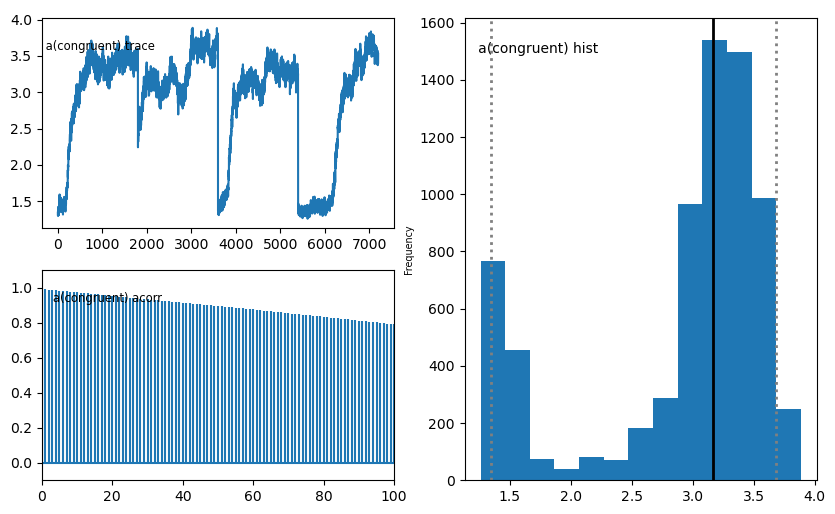

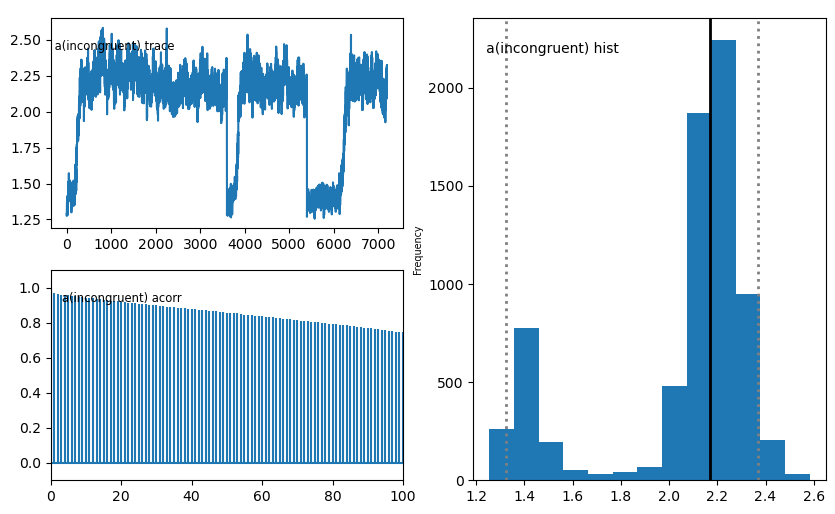

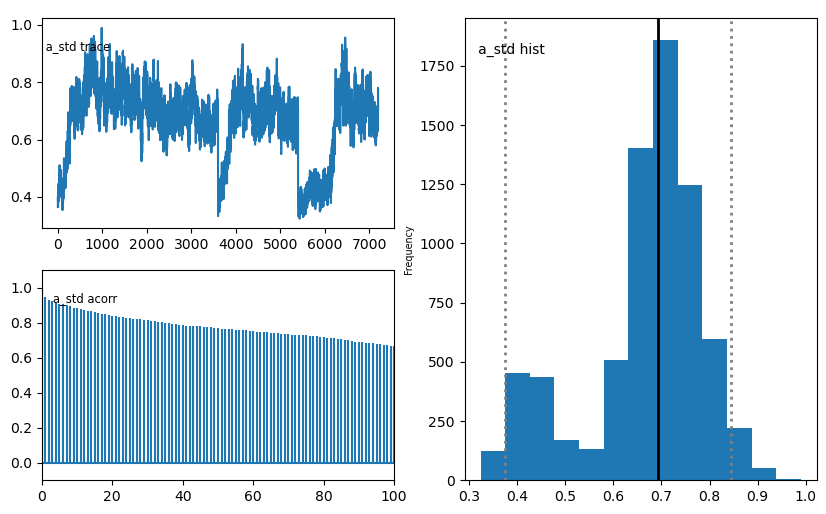

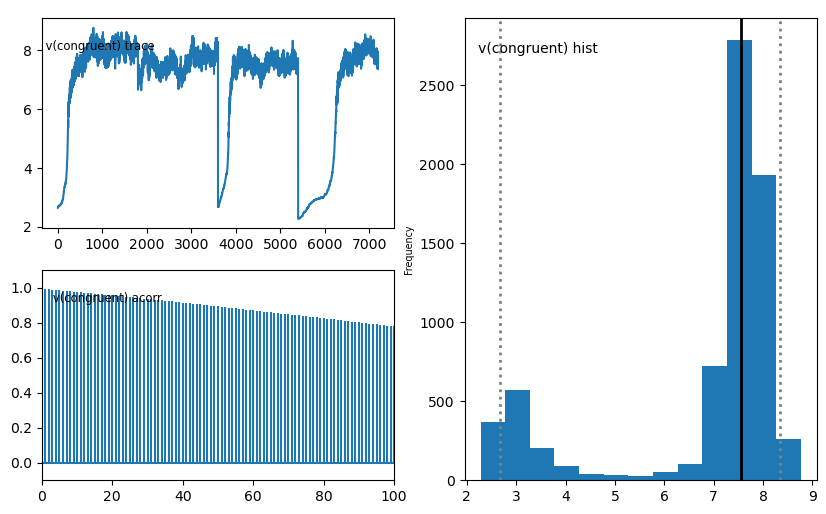

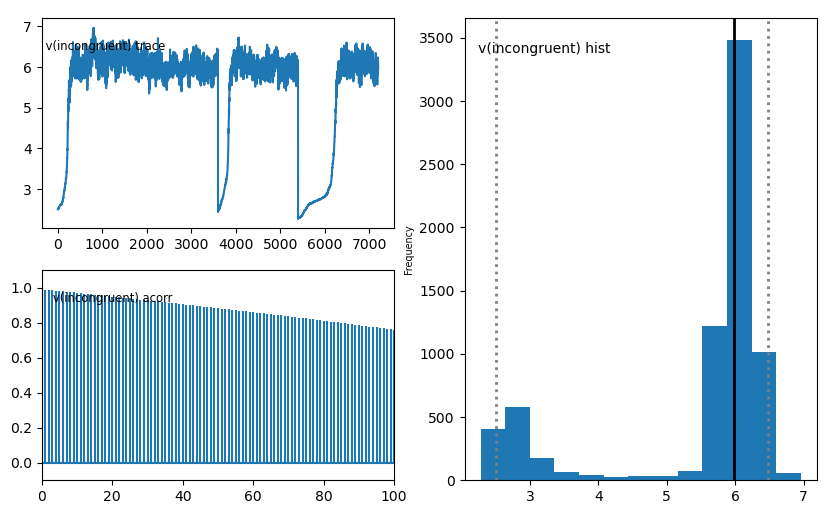

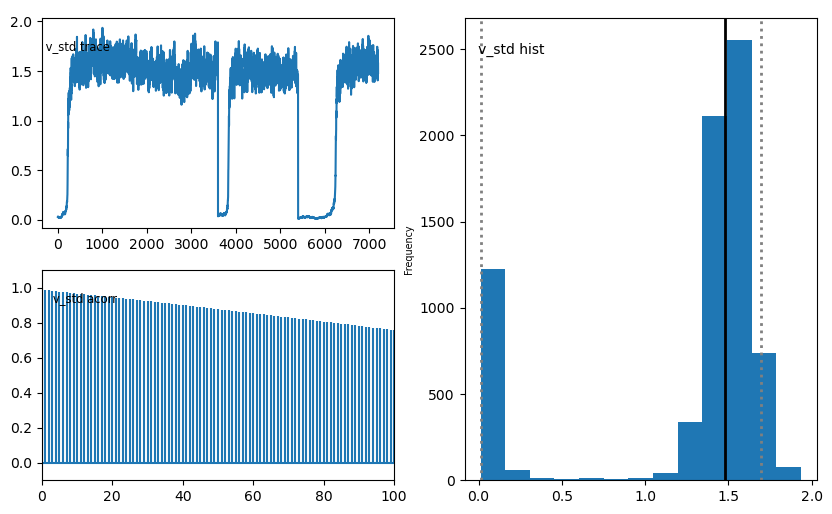

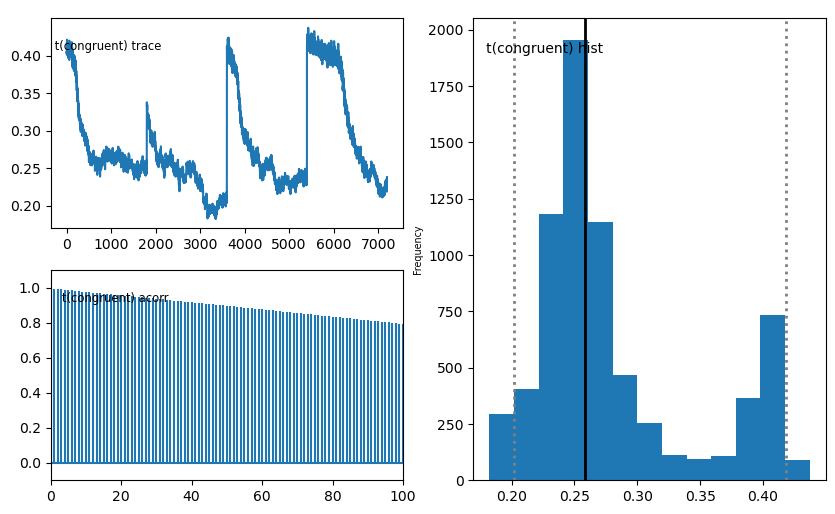

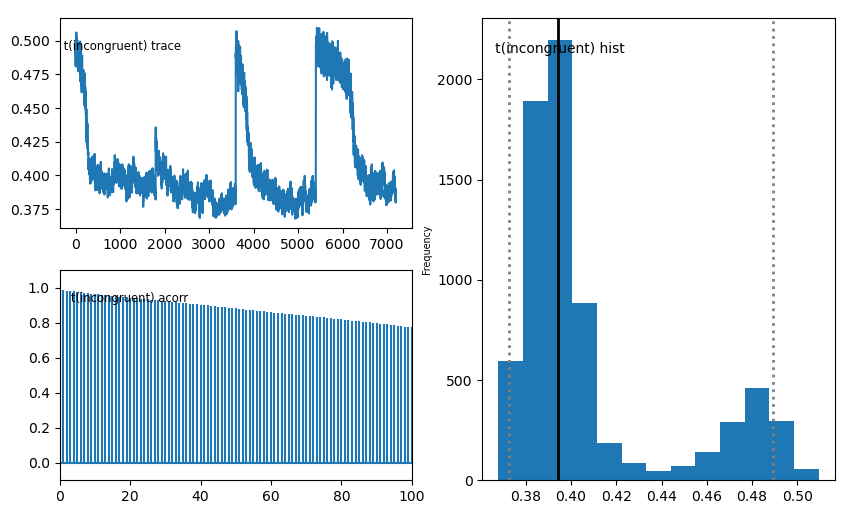

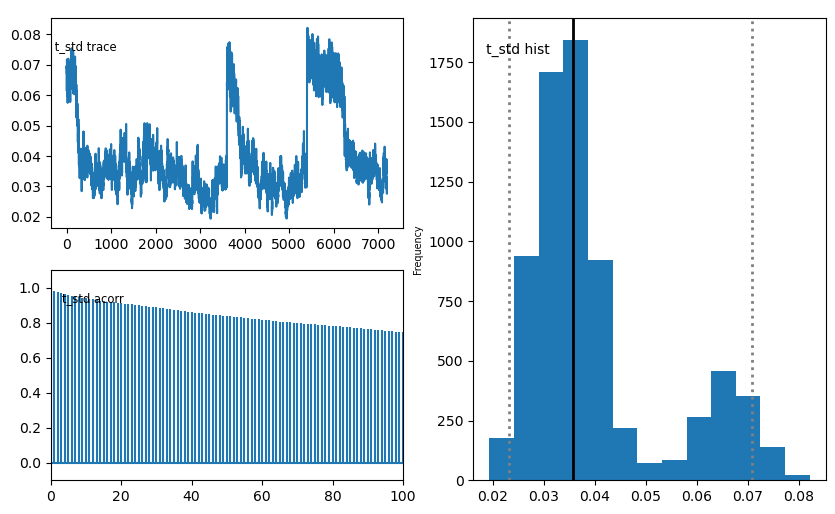

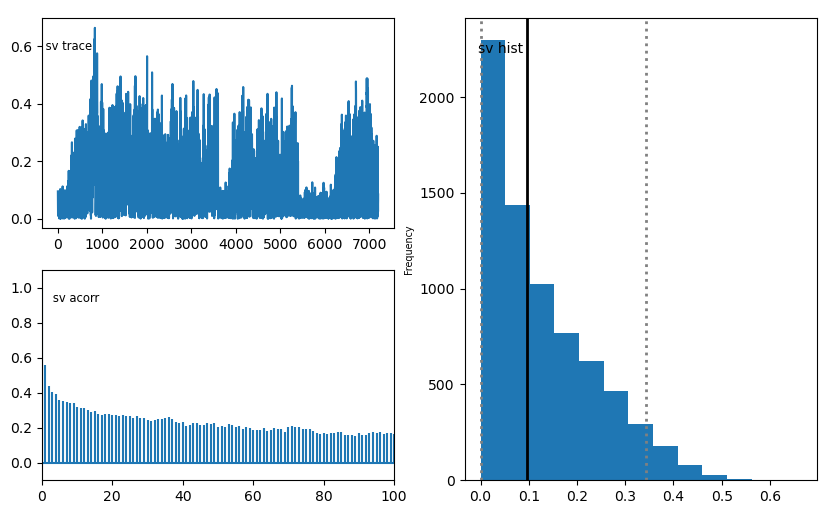

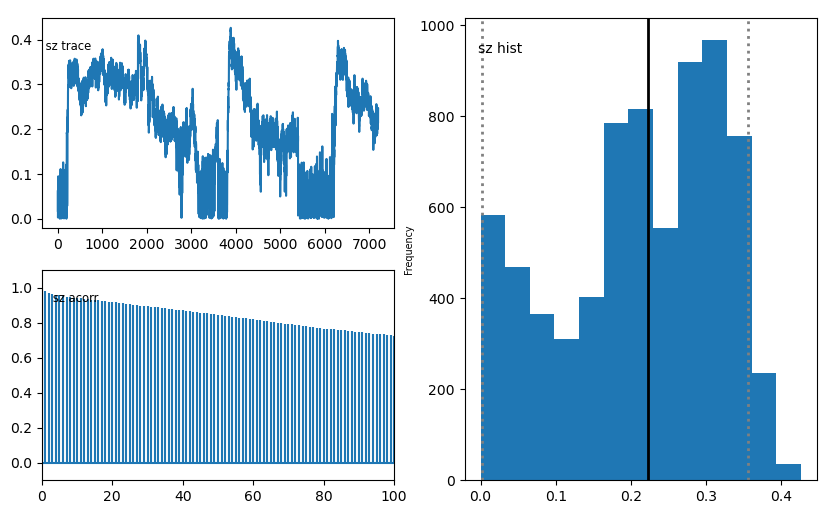

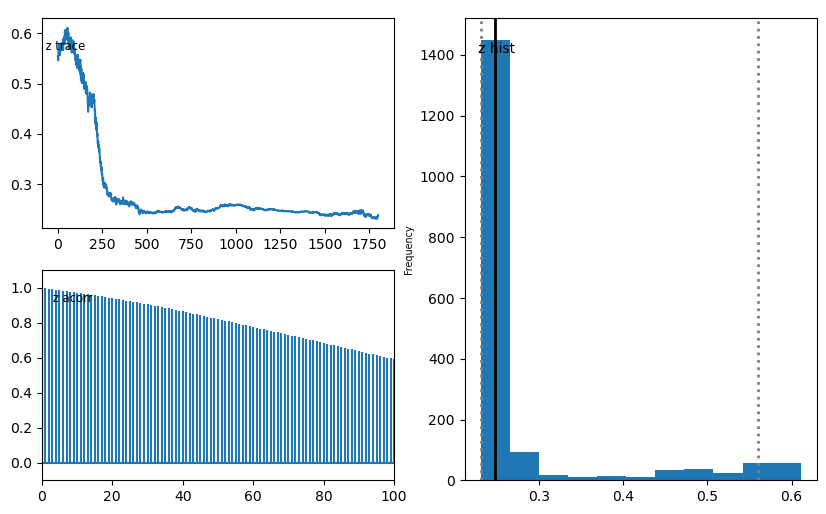

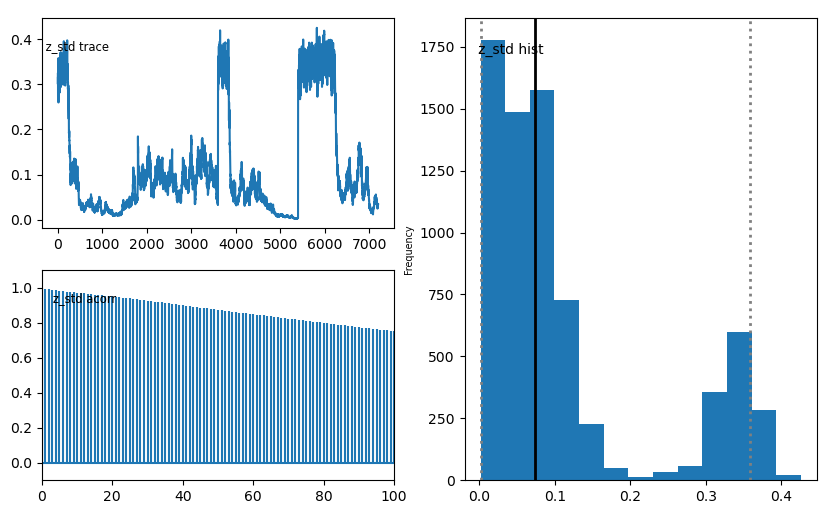

In [21]:
m.plot_posteriors()

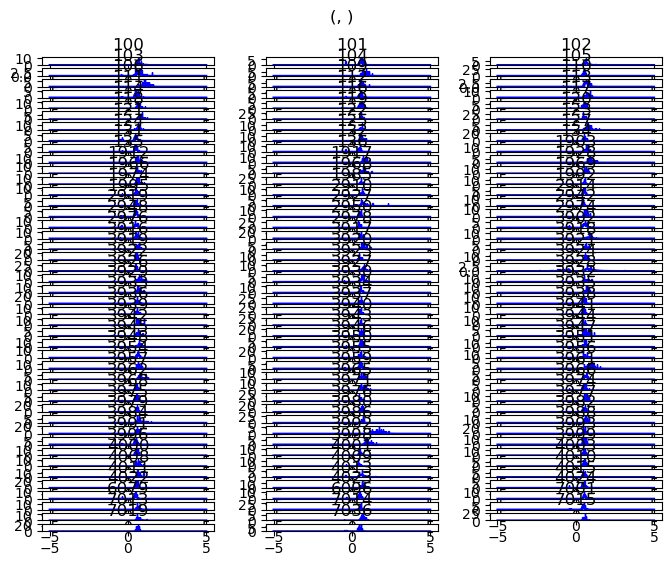

In [12]:
m.plot_posterior_predictive()

In [ ]:
models = []
for i in range(5):
    m = hddm.HDDM(data_clean, include=['a', 'v', 't', 'z', 'sv', 'sz'], depends_on={'v': 'trial_type', 
                                                                        'a': 'trial_type', 
                                                                        't': 'trial_type'})
    m.find_starting_values()
    m.sample(2000, burn=200)
    models.append(m)

gelman_rubin(models)

No model attribute --> setting up standard HDDM
Set model to full_ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 586.2 sechddm sampling elpased time:  586.602 s
No model attribute --> setting up standard HDDM
Set model to full_ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [---              10%                  ] 201 of 2000 complete in 67.0 sec

In [ ]:
stats = m1.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

In [ ]:
m0.model_config

In [ ]:
m1.plot_posteriors(['a', 't', 'v', 'z'])